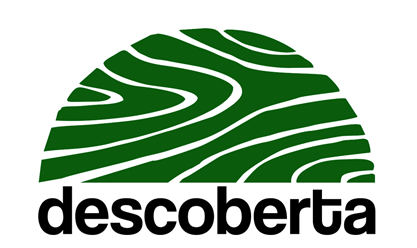

Hey, this notebook will guide you through our work, particularly the Feature Engineering and Model Selecting. As a bonus, we include our process to create the map in our slides. Please besure that your machine is using a GPU!

## Google Drive
For easier management, we stored our data on Google Drive. So please ensure that you do the same or please change the path in following way (mentioned in the comments).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

*To* write less later, we change the directory of our whole Jupyter Notebook.

In [ ]:
cd drive/MyDrive/hackathon

/content/drive/MyDrive/hackathon


## Import
Libraries we used for our project. Please ensure to install [catboost](https://catboost.ai/)
 since our primary model is based on this.





In [ ]:
!pip3 install catboost

     |████████████████████████████████| 76.1 MB 101.1 MB/s 


We used the following Libraries for
*   Pandas: Data Management 
*   NumPy: Numerical Operations
* Matplotlib & Seaborn: Plotting
* Sklearn: Models, Testing, Feature Engeeniring
* Catboost: Our main Model 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

## Reading the Data
Please ensure you have right path!!

In [ ]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

## Features
Our dataset contains categorical and continuous values. They have to be treated differently during the process (for example, standardization or normalization). We found an interesting correlation between the continuous values: The values change slightly between the neighboring cells (if we take the grid visualization). To give the features more expression power and reduce redundancies, we summed up columns with index one from the right column. For example col1 + col2; col2+col3 and so on. The analysis can be found in the Appendix.
 
Those are the continuous features.

In [ ]:
feature_names = ['slope', 'aspect', 'placurv', 'procurv', 'lsfactor', 'twi', 'sdoif']

['1_slope', '2_slope', '3_slope', '4_slope', 'Label']


<Figure size 1440x864 with 0 Axes>

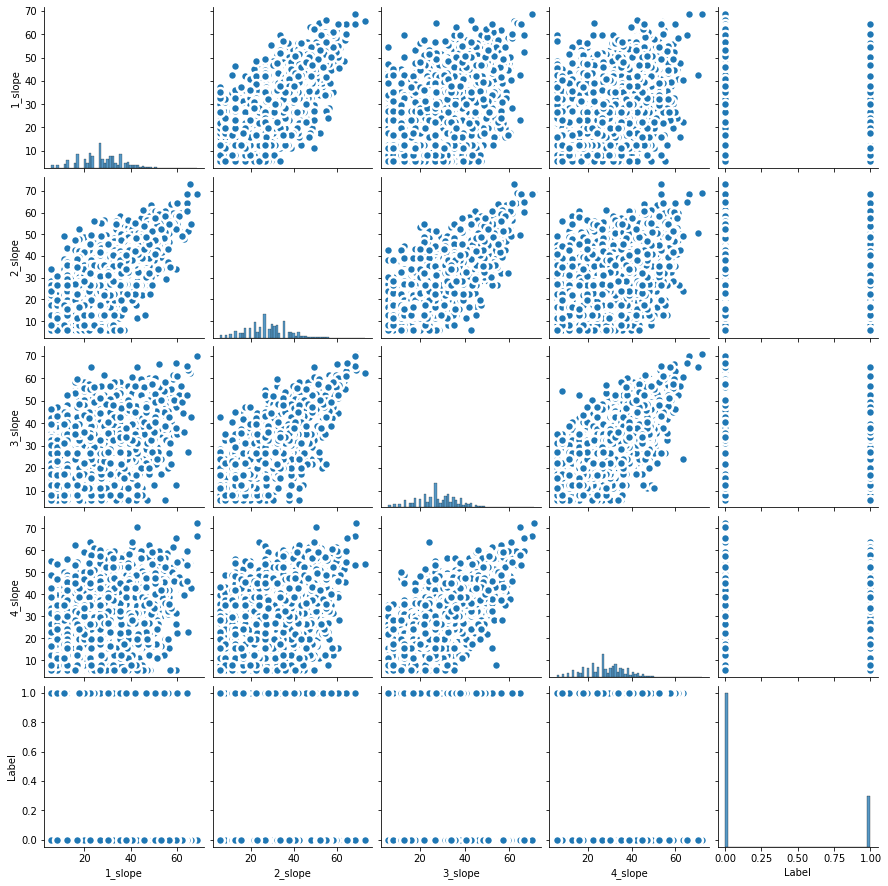

['1_aspect', '2_aspect', '3_aspect', '4_aspect', 'Label']


<Figure size 1440x864 with 0 Axes>

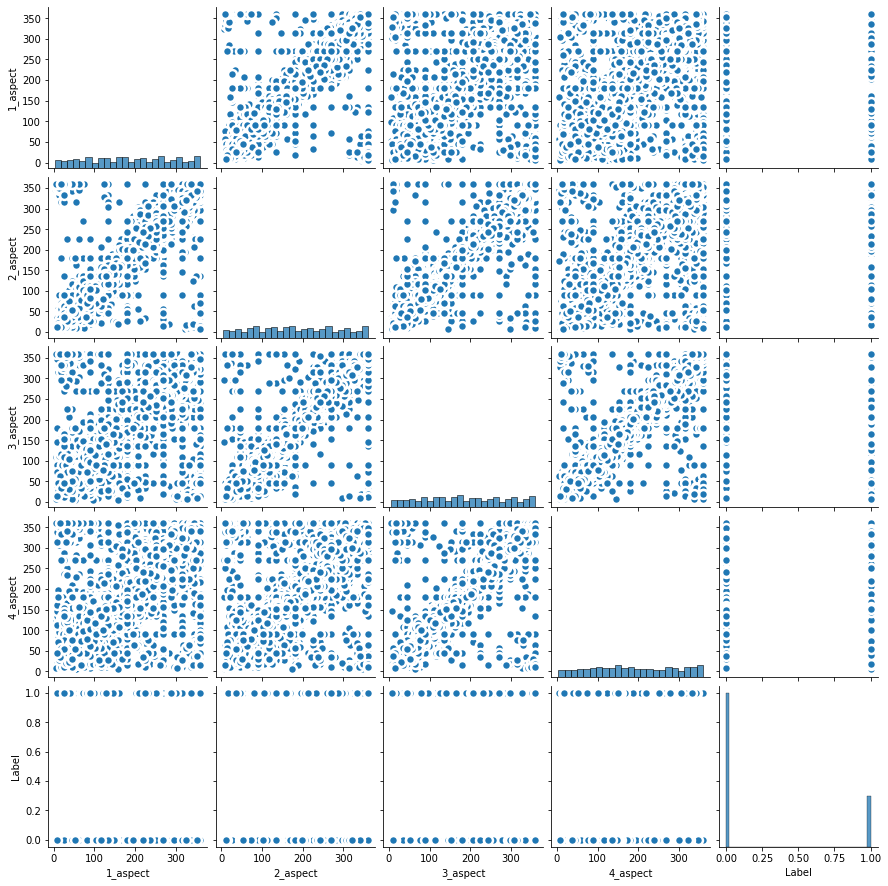

['1_placurv', '2_placurv', '3_placurv', '4_placurv', 'Label']


<Figure size 1440x864 with 0 Axes>

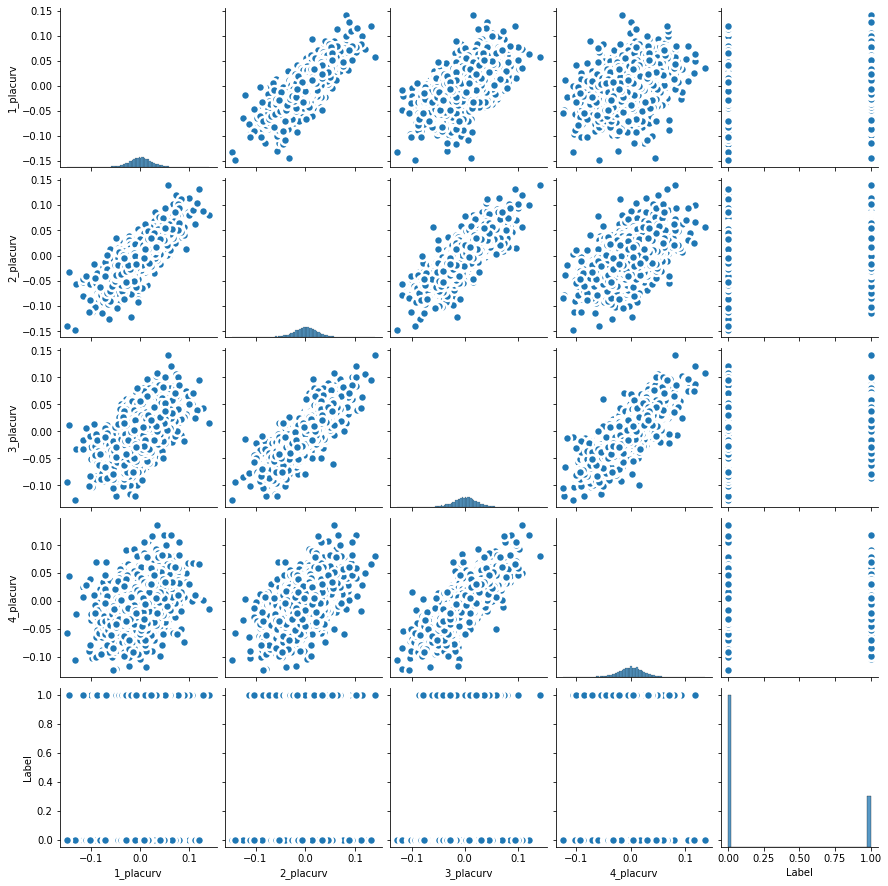

['1_procurv', '2_procurv', '3_procurv', '4_procurv', 'Label']


<Figure size 1440x864 with 0 Axes>

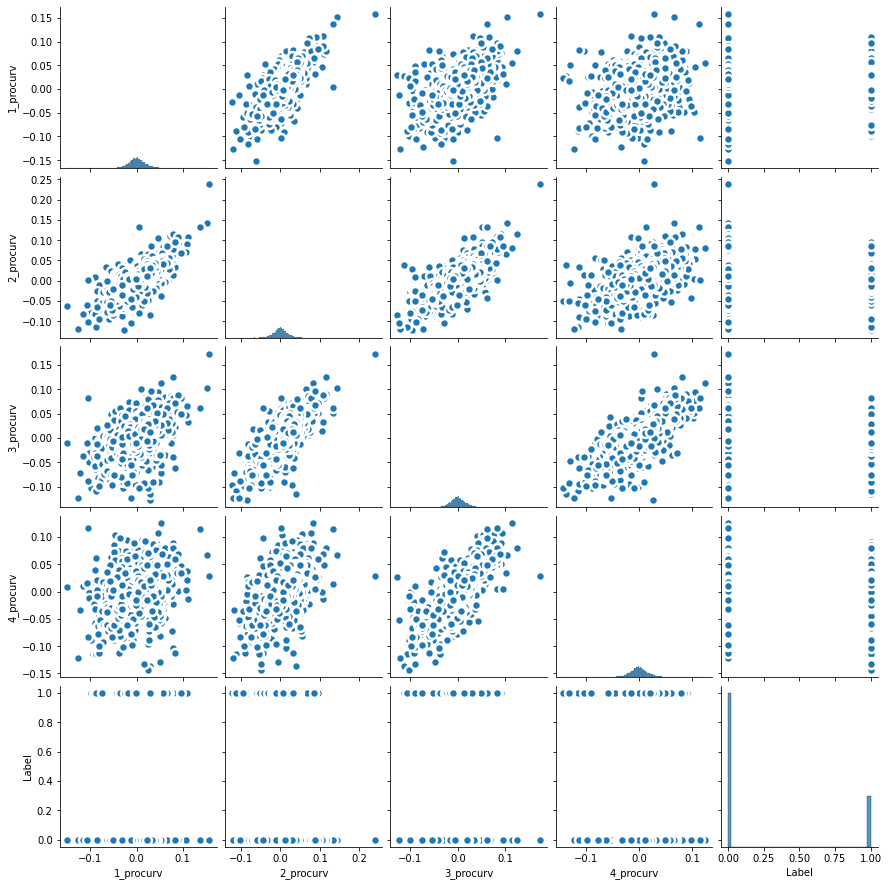

['1_lsfactor', '2_lsfactor', '3_lsfactor', '4_lsfactor', 'Label']


<Figure size 1440x864 with 0 Axes>

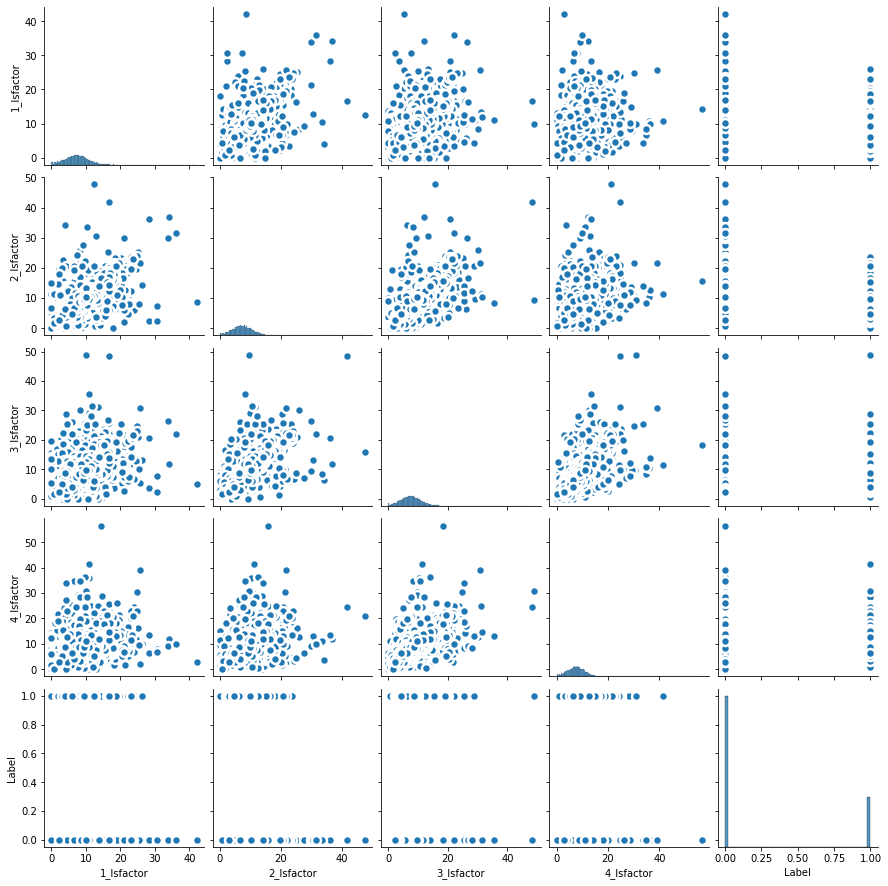

['1_twi', '2_twi', '3_twi', '4_twi', 'Label']


<Figure size 1440x864 with 0 Axes>

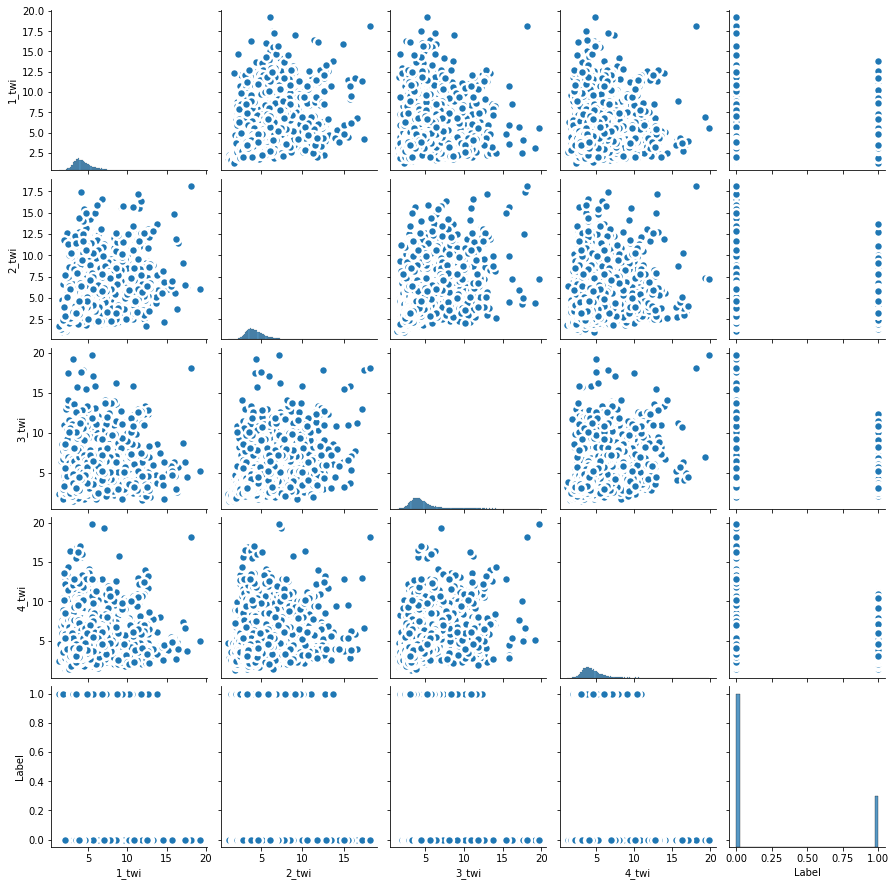

['1_sdoif', '2_sdoif', '3_sdoif', '4_sdoif', 'Label']


<Figure size 1440x864 with 0 Axes>

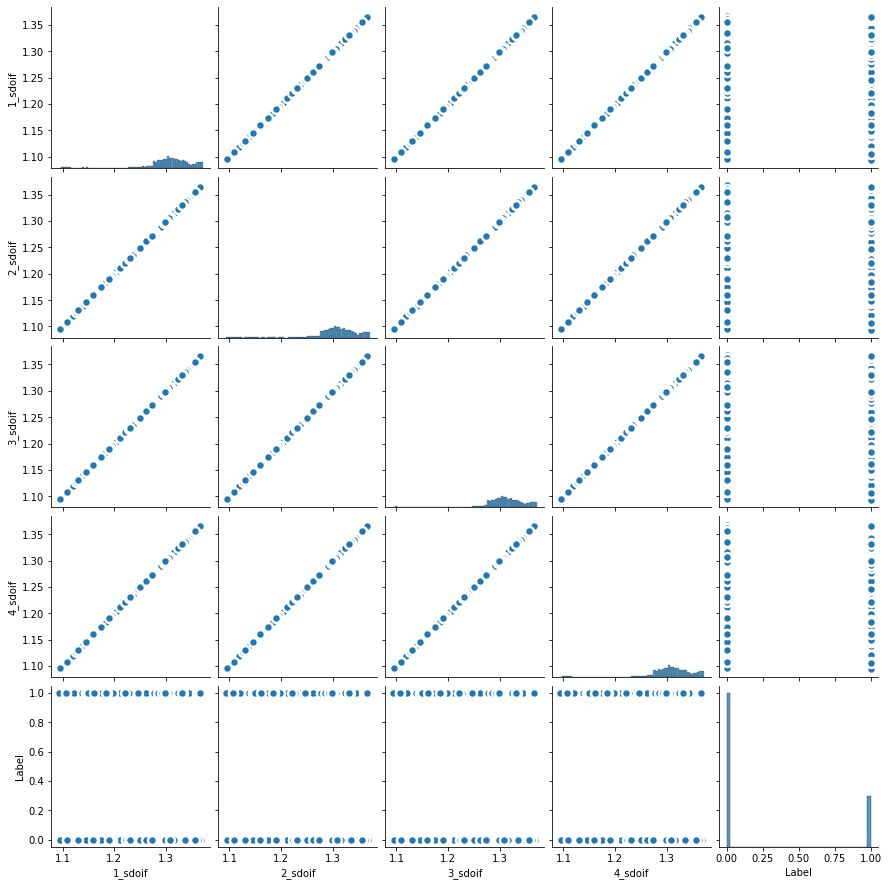

In [ ]:
for name in feature_names:  
  plt.figure(figsize = (20, 12))
  sample_elevations = [f'{i}_{name}' for i in range(1, 5)] + ['Label']
  print(sample_elevations)
  sns.pairplot(train[sample_elevations], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
  plt.show()

In [ ]:
for name in feature_names:
  for i in range(1, 25):
    # we have always make the change on the test and train set to keep the distrubition and features same
    train[f'{i}_{name}'] = train[f'{i}_{name}'] + train[f'{i+1}_{name}']
    test[f'{i}_{name}'] = test[f'{i}_{name}'] + test[f'{i+1}_{name}']
  # we don't need the last columns (no neighboor)
  train.drop(f'25_{name}', axis=1, inplace=True)
  test.drop(f'25_{name}', axis=1, inplace=True)

We tried the hint from Darius to use Binning on different scales. We lost performance (in average around 3%). So, we ended up not using it.

In [ ]:
"""
for i in range(1, 26):
  train[f'{i}_elevation'] = train[f'{i}_elevation']%20
  test[f'{i}_elevation'] = test[f'{i}_elevation']%20
"""

The dataset is unbalanced as you can see in the following image.

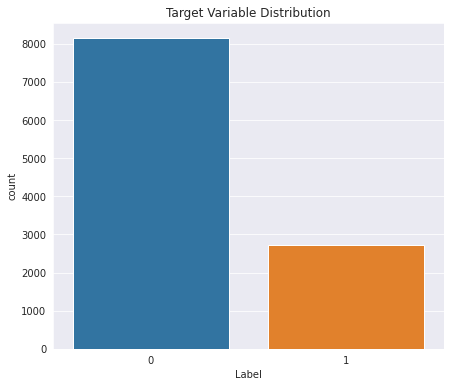

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(7, 6))
sns.countplot(x = train.Label)
plt.title('Target Variable Distribution')
plt.show()

There are different methods we tried out such as oversampling, generating new data. But undersampling worked the best for us. The size is used to have an almost balanced dataset.

In [ ]:
inds = train.index[train['Label'] == 0].tolist()
remove = np.random.choice(inds, size=5000)
train = train.drop(remove, axis=0).reset_index(drop=True) 

We are removing the categorical features to add them after the normalisation or standardisation.

In [ ]:
geog_tr = train[[f'{i}_geology' for i in range(1, 26)]]
train.drop([f'{i}_geology' for i in range(1, 26)], axis=1, inplace=True)
geog_te = test[[f'{i}_geology' for i in range(1, 26)]]
test.drop([f'{i}_geology' for i in range(1, 26)], axis=1, inplace=True)

Preparation step to split the dataset into the samples and labels. 

In [ ]:
x = train.drop(['Label'], axis=1).to_numpy()
y = train['Label'].to_numpy()
tx = test.to_numpy()

We tried the most two common scale methods, standardisation and normalisation. We tried both models within our experiments.

In [ ]:
def scale(x, tx, type_=0):
  """
  Function for scaling the dataset.
  :param x: Training Set
  :param tx: Test Set
  :param type_: 0: Standardisation (default); 1: Normalization
  :return: scalted x, scaled tx
  """
  data = np.vstack([x, tx]) # ensure same distribution
  if type_ == 1:
    scaler = Normalizer().fit(data)
    data = scaler.transform(data)
  else:
    scaler = StandardScaler().fit(data)
    data = scaler.transform(data)
  return data[:x.shape[0]], data[x.shape[0]:]

In [ ]:
x, tx = scale(x, tx, 0) 

We are adding the categorical features back to the dataset.

In [ ]:
x = np.hstack((x, geog_tr))
tx = np.hstack((tx, geog_te))

## Model
We will present our primary Model. Because of time constraints, we didn't manage to provide clean code. We first started with a Linear Regression, which we used as a base model after we made changes to our feature extraction. Linear Regression is a simple but powerful method to provide a solid baseline. After the Linear Regression, we tried Ridge Regression, which allowed us to optimize it by hyperparameter tuning (namely the lambda). After this, we moved to more advanced methods such as Random Forrest. Here we used grid search to optimize the hyperparameters. Finally, we moved to Boosting methods because they are strong in automatic binary classification. From some experimenting with different libraries we found, that Catboosting is working the best.


In [ ]:
def decide(x):
  """
  Helper (map) function, to transform the prediction from our models into the given binary label [0, 1]
  :param x: Predtiction of the model
  :return: Transformed predictions
  """
  if x <= 0.4:
    return 0
  return 1

In [ ]:
# using crossvalidation for preventing overfitting and keep track of performance
# StratifiedKFold's folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
f1s = []
test_res = []
model = None # to reuse it later
for train_ind, test_ind in skf.split(x, y):
  model = CatBoostClassifier(n_estimators=1215, task_type='GPU', verbose=0)
  x_train_fold, x_test_fold = x[train_ind], x[test_ind]
  y_train_fold, y_test_fold = y[train_ind], y[test_ind]
  model.fit(x_train_fold, y_train_fold)
  y_predic = model.predict(x_test_fold)
  y_predic = list(map(decide, y_predic))
  y_predic_te = model.predict_proba(tx)
  test_res.append(y_predic_te)
  #print(test_res)
  f1 = f1_score(y_predic, y_test_fold)
  f1s.append(f1)
  print(f1)
  
print('-------')
print(sum(f1s)/len(f1s))
print(np.mean(test_res, axis=0))

In [ ]:
model.get_feature_importance() # for future investigation

array([0.05738864, 0.27816575, 0.65820699, 0.70157258, 0.38747623,
       0.48456541, 0.21607077, 0.1773319 , 0.21209421, 0.33834832,
       0.4302376 , 0.31118308, 0.21613849, 0.13079068, 0.60083365,
       0.47735562, 0.35018126, 0.12419036, 0.23421057, 0.16540812,
       0.21848267, 0.26500817, 0.17214795, 0.2452166 , 0.25972281,
       0.31263767, 0.33429917, 0.38651076, 0.53778147, 0.43144884,
       0.43743945, 0.32353114, 1.31586837, 6.89952879, 0.77020706,
       0.56449815, 0.36050068, 1.49094983, 3.28474683, 0.44390196,
       0.6709078 , 0.29186165, 0.42444304, 0.38464293, 0.48131739,
       0.21490888, 0.16366643, 0.22181873, 0.10912273, 0.37743373,
       0.61692055, 0.68982054, 0.53904162, 0.11965805, 0.292223  ,
       0.8800535 , 0.18312137, 0.19752024, 0.1325254 , 0.29452126,
       0.30559985, 0.25330382, 0.06174322, 0.15290952, 0.12018057,
       0.33010845, 0.44070214, 0.09767879, 0.15172037, 0.14023548,
       0.19750683, 0.34389553, 0.25749715, 0.17015843, 0.28945

In [ ]:
# We are averaging over the models in the folds
a = np.mean(test_res, axis=0)
sub = list(map(decide, a[ :,1]))

Text(0.5, 1.0, 'Predicted Variable Distribution')

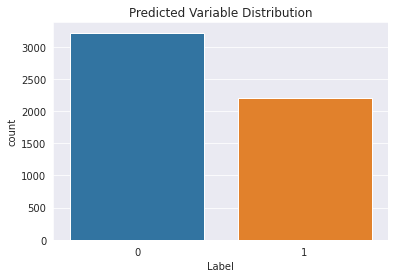

In [ ]:
y_predic = model.predict(tx)
y_predic = list(map(decide, y_predic))

sub_file = pd.DataFrame({'Sample_ID': test.Sample_ID, 'Label': sub})
sns.countplot(x = sub_file.Label)
plt.title('Predicted Variable Distribution')

In [ ]:
sub_file.to_csv('Baseline_nc888.csv', index = False)
sub_file.head()

,Sample_ID,Label
0,10865,1
1,10866,0
2,10867,0
3,10868,1
4,10869,1


## Bonus: Sattelite Map
In the following, we share the code behind our satellite map. You need access to [Google Earth Engine](https://developers.google.com/earth-engine). The populations density is taken from [GPWv411: Population Density](https://developers.google.com/earth-engine/datasets/catalog/CIESIN_GPWv411_GPW_Population_Density) dataset. The plotting of the acutely endangered regions is based on [landslide nowcast](https://gpm.nasa.gov/data/visualizations/precip-apps). You can get the used GeoJSON from [NASA's website](https://gpm.nasa.gov/data/visualizations/precip-apps) (Scroll down to the bottom, select for region: Asia, date: 23.03.2022 and for a dataset: Global Landslide Nowcast Updated Every 3 Hours). We are using the dataset because it gives us the current predictions. Alternatively, you can get the dataset from our [Google Drive](https://drive.google.com/file/d/11fjqFYOAYPa2ft7XZS1Ffk9Uw8G01Djx/view?usp=sharing).

In [ ]:
import ee #Earth Engine

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [ ]:
!pip install geemap

In [ ]:
import google.colab
import geemap.eefolium as geemap
import json
from ipyleaflet import GeoJSON
from geemap import geojson_to_ee, ee_to_geojson

In [ ]:
with open('asia_landslide_23032022.json', encoding='utf-8') as f:
    json_data = json.load(f)

In [ ]:
Map = geemap.Map(center=[22,114], zoom= 8)

In [ ]:
json_layer = GeoJSON(
    data=json_data,
    name='Landslide Predictions'
)
ee_data = geojson_to_ee(json_data)

In [ ]:
dataset = ee.ImageCollection("CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Density").first();
raster = dataset.select('unwpp-adjusted_population_density');
raster_vis = {
  "max": 1000.0,
  "palette": [
    "ffffe7",
    "FFc869",
    "ffac1d",
    "e17735",
    "f2552c",
    "9f0c21"
  ],
  "min": 0.0
}

In [ ]:
Map.addLayer(ee_data, {}, "Landslide Predictions")
Map.addLayer(raster, raster_vis, 'unwpp-adjusted_population_density', opacity=0.5);
Map.addLayerControl()

The black area is for endangered landslide areas. The other colors are related the population density.

In [ ]:
Map